In [1]:
import os
from os import path

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import spreg
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib import colors
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran
from scipy import stats

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
input_dir = "data/output/"
output_dir = "data/output/regressions"

In [3]:
# get input data
env_data = gpd.read_file(path.join(input_dir,"AGGR_DHS_buffer_4stats.shp"))# get environmental data

dhs_data = pd.read_csv("data/temp/DHSdata_aggr2join_buffer.csv")# get DHS data
dhs_data = dhs_data.iloc[: , 1:]# drop first column (old index)
dhs_data = dhs_data.drop(['geometry'], axis=1)# drop geometry column

data_gdf = pd.merge(dhs_data, env_data, on='v001', how='left')# join datasets
data_gdf = gpd.GeoDataFrame(data_gdf,geometry='geometry')# turn into GDF
data_gdf['geometry'] = data_gdf['geometry'].centroid# turn back to point geometry

data_gdf

,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,rd_len_LI,rd_pc_LI,pc_HiDen,pc_VHden,prop_Prec,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry
0,CI201200000001,CI,2012.0,1.0,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,...,0.935515,0.01155938331595235,0,0,22.22222222222224,22.22222222222222,0,0,0,POINT (-3.19847 5.97345)
1,CI201200000002,CI,2012.0,2.0,8.0,Ouest,GPS,R,6.462503,-8.211979,...,0.000000,0,0,0,100,100,0,0,0,POINT (-8.21198 6.46250)
2,CI201200000003,CI,2012.0,3.0,8.0,Ouest,GPS,R,7.274597,-8.324563,...,0.414876,0.009099259461077081,None,None,None,None,None,None,None,POINT (-8.32456 7.27460)
3,CI201200000004,CI,2012.0,4.0,6.0,Nord-Est,GPS,R,7.731449,-3.059561,...,0.000000,0,0,0,100,100,0,0,0,POINT (-3.05956 7.73145)
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,111.449423,0.5894592012967101,100,0,0,0,0,100,5.555555555555554,POINT (-5.04071 7.71383)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,...,0.150578,0.004093965954248088,0,0,21.4285714285714,21.42857142857141,0,0,0,POINT (-5.71578 6.36162)
347,CI201200000349,CI,2012.0,349.0,1.0,Centre,GPS,R,6.987534,-5.277727,...,2.964994,0.05858511109025522,0,0,0,0,0,0,0,POINT (-5.27773 6.98753)
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,43.341645,0.4133437024220832,52.38095238095239,0,19.04761904761904,19.04761904761905,0,34.92063492063492,0,POINT (-3.20042 7.13638)
349,CI201200000351,CI,2012.0,351.0,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,...,6.170473,0.1045737020213004,0,0,12.50000000000005,12.50000000000004,0,0,0,POINT (-6.51277 6.65822)


# Check input data ('data_gdf')

In [4]:
# Several buffer zones (n=74) don't have any built-up pixel (hence no settlement categorization)
data_gdf[data_gdf.pc_PrecAr.isna()].built_pix.value_counts()

0.0    74
Name: built_pix, dtype: int64

In [5]:
# (!) Several buffer zones (n=10) don't have valid GPS coordinates
data_gdf[data_gdf.LATNUM==0].v001

148    149.0
165    166.0
173    174.0
185    186.0
205    206.0
292    294.0
313    315.0
328    330.0
340    342.0
343    345.0
Name: v001, dtype: float64

In [6]:
# (!) Some buffer zones (n=5) don't have any built-up pixel but are 'urban' according to DHS
data_gdf[((data_gdf.built_pix==0)|(data_gdf.built_pix.isna()))&(data_gdf.URBAN_RURA=='U')][['pc_PrecAr','den_med']]

,pc_PrecAr,den_med
90,None,NaN
207,None,8.539253
227,None,NaN
299,None,NaN
337,None,NaN


#### >> Remove invalid observations ('urban' with no built-up area)

In [7]:
excl_index_lst = data_gdf[(((data_gdf.built_pix==0)|(data_gdf.built_pix.isna()))&(data_gdf.URBAN_RURA=='U'))
                          |(data_gdf['LATNUM']==0)].index.to_list()
data_gdf_check = data_gdf.copy()
data_gdf_check = data_gdf_check[data_gdf_check.index.isin(list(set(data_gdf_check.index.to_list())-set(excl_index_lst)))]
data_gdf_check

,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,rd_len_LI,rd_pc_LI,pc_HiDen,pc_VHden,prop_Prec,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry
0,CI201200000001,CI,2012.0,1.0,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,...,0.935515,0.01155938331595235,0,0,22.22222222222224,22.22222222222222,0,0,0,POINT (-3.19847 5.97345)
1,CI201200000002,CI,2012.0,2.0,8.0,Ouest,GPS,R,6.462503,-8.211979,...,0.000000,0,0,0,100,100,0,0,0,POINT (-8.21198 6.46250)
2,CI201200000003,CI,2012.0,3.0,8.0,Ouest,GPS,R,7.274597,-8.324563,...,0.414876,0.009099259461077081,None,None,None,None,None,None,None,POINT (-8.32456 7.27460)
3,CI201200000004,CI,2012.0,4.0,6.0,Nord-Est,GPS,R,7.731449,-3.059561,...,0.000000,0,0,0,100,100,0,0,0,POINT (-3.05956 7.73145)
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,111.449423,0.5894592012967101,100,0,0,0,0,100,5.555555555555554,POINT (-5.04071 7.71383)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,...,0.150578,0.004093965954248088,0,0,21.4285714285714,21.42857142857141,0,0,0,POINT (-5.71578 6.36162)
347,CI201200000349,CI,2012.0,349.0,1.0,Centre,GPS,R,6.987534,-5.277727,...,2.964994,0.05858511109025522,0,0,0,0,0,0,0,POINT (-5.27773 6.98753)
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,43.341645,0.4133437024220832,52.38095238095239,0,19.04761904761904,19.04761904761905,0,34.92063492063492,0,POINT (-3.20042 7.13638)
349,CI201200000351,CI,2012.0,351.0,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,...,6.170473,0.1045737020213004,0,0,12.50000000000005,12.50000000000004,0,0,0,POINT (-6.51277 6.65822)


# Explore correlations & select relevant ind. variables

### Clean data & replace all nan by 0s

In [8]:
# Get data
data = data_gdf_check.copy()# here we drop obs. with inconsistencies ('urban' buffers with no built-up pixel)

# Drop unused columns
drop_list = ['DHSID','DHSCC','DHSCLUST','DHSREGNA','DHSYEAR','DHSREGCO','DHSREGNA',
             'SOURCE','LATNUM','LONGNUM','ALT_GPS','ALT_DEM','DATUM',
             'cU5_0','cU5_2','pop_U5','cU5bis_0','cU5bis_2','pop_U5bis',
             'pp_imp_w','pp_unim_w','pp_imp_s','pp_unim_s','pp_imp_h','pp_unim_h',
             'pp_bas_w','pp_noba_w','pp_bas_s','pp_noba_s','pp_bas_h','pp_noba_h',
             'wcnt_2','wcnt_0','wcnt_1','wcnt_3','wcnt_4','wcnt_5','wpop',
             'wcntBis_2','wcntBis_0','wcntBis_1','wcntBis_3','wcntBis_4','wcntBis_5','wpopBis',
             'den_count','00_14_cnt','90_00_cnt','75_90_cnt','b75_cnt',
             'RdLen_LI1','RdLen_LI2','RdLen_LI3','RdLen_LI4','RdLen_LI5',
             'pc_PrecAr',# drop 'pc_PrecAr' & keep 'prop_Prec' (they are the same)
             'pc_WnoedBis'# drop education level calculated with non-de jure population
             ]
for col in drop_list:
    if col in data.columns.to_list():
        data = data.drop(col,axis='columns')

# Rename cols (first character in var name must be string)
data = data.rename(columns={'prop_Prec':'pc_PrecAr'})

# Add variable: dense precarious areas (based on previous analysis, cf. notebook '3a_1')
data['prop_4342'] = np.nan
data['prop_4342'] = data['prop_19043']+data['prop_19042']
data['pc_DenPrAr'] = np.nan
data['pc_DenPrAr'] = data['prop_4342']/data['prop_190']

# Replace NaNs by 0s
data = data.fillna(0)

# Set non-numeric variable types to 'float' (except for categorical variables)
var_list = list(data.columns.difference(['v001','URBAN_RURA','geometry']))
for v in var_list:
    if str(data[v].dtype) == 'object':
        data[v] = data[v].astype(float)
    else:
        data[v] = data[v]
        
#Check result
data

,v001,URBAN_RURA,wt,dPrevU5,dPrevU5bis,pc_imp_w,pc_bas_w,pc_imp_s,pc_bas_s,pc_imp_h,...,rd_pc_LI,pc_HiDen,pc_VHden,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry,prop_4342,pc_DenPrAr
0,1.0,R,1.803150,0.041667,0.041667,27.160494,27.160494,39.506173,11.728395,0.000000,...,0.011559,0.000000,0.0,22.222222,0.0,0.000000,0.000000,POINT (-3.19847 5.97345),0.0,0.0
1,2.0,R,0.997934,0.233333,0.212121,78.089888,69.662921,5.056180,0.000000,0.980392,...,0.000000,0.000000,0.0,100.000000,0.0,0.000000,0.000000,POINT (-8.21198 6.46250),0.0,0.0
2,3.0,R,0.192455,0.090909,0.090909,53.571429,48.214286,7.142857,0.000000,0.000000,...,0.009099,0.000000,0.0,0.000000,0.0,0.000000,0.000000,POINT (-8.32456 7.27460),0.0,0.0
3,4.0,R,0.470353,0.148148,0.178571,100.000000,87.591241,24.087591,2.919708,0.000000,...,0.000000,0.000000,0.0,100.000000,0.0,0.000000,0.000000,POINT (-3.05956 7.73145),0.0,0.0
4,5.0,U,0.922173,0.210526,0.250000,100.000000,100.000000,67.692308,18.461538,15.625000,...,0.589459,100.000000,0.0,0.000000,0.0,100.000000,5.555556,POINT (-5.04071 7.71383),0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,348.0,R,1.532898,0.133333,0.133333,76.595745,73.404255,38.829787,16.489362,8.403361,...,0.004094,0.000000,0.0,21.428571,0.0,0.000000,0.000000,POINT (-5.71578 6.36162),0.0,0.0
347,349.0,R,0.537444,0.162791,0.159091,96.381579,65.131579,27.631579,22.368421,100.000000,...,0.058585,0.000000,0.0,0.000000,0.0,0.000000,0.000000,POINT (-5.27773 6.98753),0.0,0.0
348,350.0,U,0.299906,0.272727,0.230769,83.544304,83.544304,96.202532,11.392405,10.000000,...,0.413344,52.380952,0.0,19.047619,0.0,34.920635,0.000000,POINT (-3.20042 7.13638),0.0,0.0
349,351.0,R,1.270933,0.347826,0.347826,93.846154,93.846154,16.923077,9.230769,8.333333,...,0.104574,0.000000,0.0,12.500000,0.0,0.000000,0.000000,POINT (-6.51277 6.65822),0.0,0.0


In [9]:
# Drop observations without any built-up pixel
print('dropped obs. without any built-up pixel:',data.shape[0]-data[data['built_pix']>0].shape[0])
data = data[data['built_pix']>0].copy()
print('new dataset shape:',data.shape)

dropped obs. without any built-up pixel: 69
new dataset shape: (267, 137)


In [10]:
# Drop observations with low levels of urbanization
print('dropped obs. with low urb. level:',data.shape[0]-data[data['prop_190']>data['prop_190'].mean()].shape[0])
data = data[data['prop_190']>data['prop_190'].mean()]
print('new dataset shape:',data.shape)

dropped obs. with low urb. level: 162
new dataset shape: (105, 137)


### STEPWISE FEATURE SELECTION METHOD:  Combine "forward" and "backward" regressions (to avoid multicollinearity)  
Features are selected based on their p-values after running the forward and backward regressions

In [11]:
# Format data for stepwise selection

# Get data (copy of filtered dataset)
dbf_c = data.copy()

# Indicate dependent variable
dep_var = 'dPrevU5'

# Scale values (min/max) of ind. variables
ind_cols = dbf_c.columns.difference(['URBAN_RURA','v001','wt',
                                     'dPrevU5bis',
                                     'geometry']
                                    ).to_list()
for var in ind_cols:
    dbf_c[var] = ((dbf_c[var] - dbf_c[var].min())/
                  (dbf_c[var].max() - dbf_c[var].min()))

# Check that all data types are numeric
lst = []
for col in dbf_c[ind_cols].columns.to_list():
    lst = lst+[str(dbf_c[col].dtype)]
# Function to get unique values
def unique(list1):
    unique_list = []
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)
# Show list of unique data types (all must be numeric)
print("the data type(s) is/are:")
unique(lst)

# Check for NaNs (list columns with NaNs eventually generated by min/max scaler):
lst = []
for var in dbf_c[ind_cols].columns.to_list():
    if dbf_c[dbf_c[var].isna()].shape[0]>0:
        lst = lst+[var]
if len(lst)>0:
    print('exluding following columns containing nan values:',lst)
    for var in lst:
        sel_cols = dbf_c.columns.difference(lst)
        dbf_c = dbf_c[sel_cols]
else:
    print('all columns OK (no cells with nan values)')

# Check min/max values:
print('min. values for indep. variables:',dbf_c[list(set(ind_cols)-set(lst))].min().unique())
print('max. values for indep. variables:',dbf_c[list(set(ind_cols)-set(lst))].max().unique())

# Update ind_cols
# 1. drop dependent & control variables:
exclude_lst = ['dPrevU5',# exlude dep. variable from stepwise process
               'dPrevU5bis',# exlude dep. variable (bis) from stepwise process
               'pc_bas_w','pc_bas_s',# exlude control variables from stepwise process (WASH + education)
               'pc_imp_w','pc_imp_s','pc_imp_h',
               'pc_Wnoed'
              ]
# 2. drop obsolete variables (focus on ESA CCI LC):
exclude_lst2 = ['pc_00_14','pc_90_00','pc_75_90','pc_b75',# exclude GHS variables
               ]
# 3. drop morphological indicators that are hardly interpretable (subtypes of 'precarious' areas)
exclude_lst3 = []
string_lst = ['edge_1901','frac_1901',
              'edge_1902','frac_1902',
              'edge_1903','frac_1903',
              'edge_1904','frac_1904'
             ]
for s in string_lst:
    exclude_lst3 = exclude_lst3+list(filter(lambda x: s in x, dbf_c.columns.to_list()))
# 3. update list (dropping NaNs eventually generated by min/max scaler)
ind_cols = sorted(list(set(ind_cols)-set(lst+exclude_lst+exclude_lst2+exclude_lst3)))
print('columns dropped from ind_cols :',lst+exclude_lst+exclude_lst2+exclude_lst3)

# Check data
dbf_c

the data type(s) is/are:
float64
exluding following columns containing nan values: ['edge_110', 'edge_160', 'edge_180', 'edge_19011', 'edge_19021', 'edge_60', 'frac_110', 'frac_160', 'frac_180', 'frac_19011', 'frac_19021', 'frac_60', 'prop_110', 'prop_160', 'prop_180', 'prop_19011', 'prop_19021', 'prop_60']
min. values for indep. variables: [0.]
max. values for indep. variables: [1.]
columns dropped from ind_cols : ['edge_110', 'edge_160', 'edge_180', 'edge_19011', 'edge_19021', 'edge_60', 'frac_110', 'frac_160', 'frac_180', 'frac_19011', 'frac_19021', 'frac_60', 'prop_110', 'prop_160', 'prop_180', 'prop_19011', 'prop_19021', 'prop_60', 'dPrevU5', 'dPrevU5bis', 'pc_bas_w', 'pc_bas_s', 'pc_imp_w', 'pc_imp_s', 'pc_imp_h', 'pc_Wnoed', 'pc_00_14', 'pc_90_00', 'pc_75_90', 'pc_b75', 'edge_19012', 'edge_19013', 'edge_19014', 'frac_19012', 'frac_19013', 'frac_19014', 'edge_19022', 'edge_19023', 'edge_19024', 'frac_19022', 'frac_19023', 'frac_19024', 'edge_19031', 'edge_19032', 'edge_19033', 'e

,RdLenTot,URBAN_RURA,ac_ppt16,built_pix,dPrevU5,dPrevU5bis,den_med,edge_1,edge_10,edge_100,...,prop_4342,prop_50,prop_62,rdTt_BtHa,rd_len_LI,rd_pc_LI,std_ppt16,std_tmx16,v001,wt
4,0.726337,U,0.249834,0.93,0.385965,0.250000,0.179513,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.362281,0.828099,1.000000,0.081549,0.641519,5.0,0.922173
8,0.754417,U,0.922412,0.97,0.000000,0.000000,0.127529,0.000000,0.076741,0.0,...,0.000000,0.0,0.0,0.361640,0.393219,0.320465,0.566372,0.352434,9.0,1.012745
9,0.423385,U,0.275225,0.81,0.666667,0.363636,0.099213,0.579649,0.066469,0.0,...,0.000000,0.0,0.0,0.159849,0.336171,0.580913,0.186488,0.447171,10.0,0.897664
10,0.595159,U,0.243304,0.68,0.229167,0.125000,0.077544,0.515625,0.329748,0.0,...,0.000000,0.0,0.0,0.414241,0.504663,0.663492,0.078585,0.625185,11.0,0.572191
11,0.371622,U,0.000000,0.49,0.000000,0.000000,0.019944,0.654447,0.263799,0.0,...,0.000000,0.0,0.0,0.313841,0.135875,0.175300,0.000000,0.198452,12.0,0.635868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,0.406541,U,0.507757,0.62,0.458333,0.235294,0.063016,0.620082,0.399524,0.0,...,0.000000,0.0,0.0,0.254364,0.355885,0.654737,0.080602,0.511101,343.0,0.331017
342,0.653970,U,0.931351,0.69,0.458333,0.250000,0.871233,0.445684,0.000000,0.0,...,0.236832,0.0,0.0,0.467684,0.626202,0.788857,0.621533,0.381188,344.0,0.305687
345,0.720671,U,0.255635,0.99,0.096491,0.052632,0.126425,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.322722,0.666799,0.763343,0.081020,0.641773,347.0,1.107114
348,0.321400,U,0.453693,0.30,0.500000,0.230769,0.009784,0.515625,0.501218,0.0,...,0.000000,0.0,0.0,0.446298,0.264909,0.583707,0.089395,0.619384,350.0,0.299906


In [12]:
print('length:',len(ind_cols))
ind_cols

length: 77


['RdLenTot',
 'ac_ppt16',
 'built_pix',
 'den_med',
 'edge_1',
 'edge_10',
 'edge_100',
 'edge_11',
 'edge_120',
 'edge_122',
 'edge_130',
 'edge_170',
 'edge_190',
 'edge_20',
 'edge_210',
 'edge_30',
 'edge_40',
 'edge_50',
 'edge_62',
 'frac_1',
 'frac_10',
 'frac_100',
 'frac_11',
 'frac_120',
 'frac_122',
 'frac_130',
 'frac_170',
 'frac_190',
 'frac_20',
 'frac_210',
 'frac_30',
 'frac_40',
 'frac_50',
 'frac_62',
 'mn_ppt16',
 'mn_tmax16',
 'pc_DenPrAr',
 'pc_HiDen',
 'pc_PrecAr',
 'pc_VHden',
 'pc_VPrcAr',
 'pc_VWelIl',
 'pc_WelIll',
 'prop_1',
 'prop_10',
 'prop_100',
 'prop_11',
 'prop_120',
 'prop_122',
 'prop_130',
 'prop_170',
 'prop_190',
 'prop_19012',
 'prop_19013',
 'prop_19014',
 'prop_19022',
 'prop_19023',
 'prop_19024',
 'prop_19031',
 'prop_19032',
 'prop_19033',
 'prop_19034',
 'prop_19042',
 'prop_19043',
 'prop_19044',
 'prop_20',
 'prop_210',
 'prop_30',
 'prop_40',
 'prop_4342',
 'prop_50',
 'prop_62',
 'rdTt_BtHa',
 'rd_len_LI',
 'rd_pc_LI',
 'std_ppt16',
 '

In [12]:
# source: https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

def stepwise_selection(data, target, SL_in=0.1, SL_out=0.1):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return best_features

best_features = stepwise_selection(dbf_c[ind_cols], dbf_c[dep_var], SL_in=0.1, SL_out=0.1)
best_features

['prop_4342', 'prop_19013', 'frac_40', 'edge_190']

### SPEARMAN CORRELATIONS
Verify consistency of stepwise seletion by analyzing individual Spearman correlation coefficients  
Check all significant correlations (P<0.1)

In [13]:
# Calculate spearman correlations & p-values

# NOTE: Many variables show ZERO-CLUSTERS (many obs. where ind. var. == 0)

# Create dataframe
spear_corr_df = pd.DataFrame()

# Run Spearman correlations for each variable
for var in dbf_c[ind_cols+exclude_lst].columns.difference(['dPrevU5','dPrevU5bis']).to_list():
    spear_r = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[0]
    spear_r_p = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[1]
    obs_var = dbf_c[dbf_c[var]>0].shape[0]
    df = pd.DataFrame([[spear_r, spear_r_p, obs_var]])
    df.index = [var]
    spear_corr_df = spear_corr_df.append(df)
    
# Select significant variables :

# P-value threshold: < 0.1
p_val = 0.1

# List of significant environmental variables, according to criteria above:
spear_corr_df.columns = ["SpCoPrv12","Pval","N_obs>0"]
spear_corr_df_sel_bis = spear_corr_df[(spear_corr_df['Pval']<p_val)]

print("number of sign. variables : ",
      spear_corr_df_sel_bis.shape[0],
      "(out of ",
      spear_corr_df.shape[0],")")

print("p-val. threshold:",p_val)

spear_corr_df_sel_bis

number of sign. variables :  10 (out of  87 )
p-val. threshold: 0.1


,SpCoPrv12,Pval,N_obs>0
edge_1,0.216220,0.026736,89
frac_40,-0.199276,0.041548,34
mn_tmax16,-0.161767,0.099218,104
pc_DenPrAr,0.238022,0.014483,42
pc_PrecAr,0.203502,0.037328,89
pc_VPrcAr,0.186248,0.057130,20
prop_1,0.250857,0.009847,89
prop_19042,0.214156,0.028257,19
prop_19043,0.230395,0.018055,42
prop_4342,0.240703,0.013382,42


In [14]:
# Check correlations for variables selected from stepwise selection

spear_corr_stepwise_sel = pd.DataFrame()

for var in best_features:
    spear_r = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[0]
    spear_r_p = stats.spearmanr(dbf_c[dep_var],dbf_c[var])[1]
    obs_var = dbf_c[dbf_c[var]>0].shape[0]
    df = pd.DataFrame([[spear_r, spear_r_p, obs_var]])
    df.index = [var]
    spear_corr_stepwise_sel = spear_corr_stepwise_sel.append(df)
    
spear_corr_stepwise_sel.columns = ["SpCoPrv12","Pval","N_obs>0"]

spear_corr_stepwise_sel

,SpCoPrv12,Pval,N_obs>0
prop_4342,0.240703,0.013382,42
prop_19013,-0.093338,0.343615,9
frac_40,-0.199276,0.041548,34
edge_190,-0.002061,0.983356,101


### Final list of variables for regression  

#### >> Selection based both on (1) stepwise regression and (2) Spearman correlation filter

#### Notes on stepwise selection:
Most variables selected show very poor Spearman correlation P values (>0.2), and were therefore exluded.  
Based on the Spearman correlations filter done afterwards, the retained variables are: 'prop_4342' and 'frac_40'.

#### Notes on spearman correlations:  
We can identify a global trend, where areas with high-density/low-illumination (classes '19043','19042', 'pc_PrecAr' or 'prop_1') are all positively correlated to diarrhoea. 

#### Precarious areas (added new composite variable '4342')
Based on the observations regarding classes '19043' & '19042', a new composite variable was created for dense, precarious built-up areas ('4342'), merging the proportions of the two aforementioned built-up patches. In fact, to avoid multicollinearity, it is certainly more interesting to use ONE variable related to precarious areas, instead of several.  
(!) In this subset, only 43 obs. (located in Abidjan and San Pédro) have such built-up patches ('4342'); regarding patch '19042', there are only 20 obs., all located in Abidjan.

#### Urban areas
The overall extent and morphology of 'urban' areas (class '190') per se does not seem to affect diarrhoea. However, the quality of urbanization (% of built up areas considered precarious) does. This is visible in the scatterplot analysis: urbanization with higher 'pc_PrecAr' shows significant correlation with diarrhoea. 

In [15]:
# Selected indep. variable + control variables added to list

# Control variables: based on litterature
control_list = ['pc_bas_w','pc_bas_s'#,'pc_imp_h', #control variables related to WASH
                #control variable related to education
                ,'pc_Wnoed'
                #control variables related to climate
                #,'mn_ppt16'#,'mn_tmax16'
               ]

# Independent variables (A): variables passing both stepwise selection AND Spearman correlation filter
ind_var_list_ftot = sorted(spear_corr_stepwise_sel[spear_corr_stepwise_sel['Pval']<0.1].index.to_list())

# Independent variables (B): manually selected variables (based on model performance and variables' distribution)
ind_var_list_fsel = [#'frac_40',# excluded based on distribution (see below)
                     'prop_4342',
                     #'prop_1',# added based on Spearman correlation (most significant variable)
                    ]

frac_40 ,non-adjusted


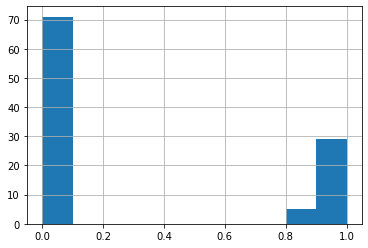

prop_4342 ,non-adjusted


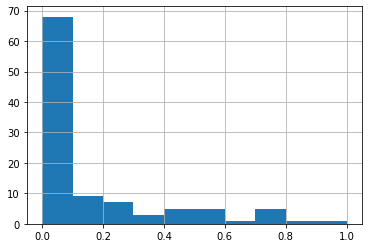

In [16]:
for var in ind_var_list_ftot:
    print(var,',non-adjusted')
    dbf_c[var].hist()
    plt.show()

In [17]:
# (A) variables from STEPWISE SELECTION
#reg_var_list = control_list + ind_var_list_ftot

# (B) MANUALLY SELECTED variables from stepwise and correlation matrix
reg_var_list = control_list + ind_var_list_fsel

print('reg_var_list:')
print(reg_var_list)

reg_var_list:
['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']


# OLS regression with DHS weights & spatial diagnostics

### >> Iterative, manual selection of variables based on: (1) filtered variables (stepwise + corr. matrix) AND (2) regression model (control + selected variables)

#### >> OLS with non-spatial weights (cluster weights given by DHS)

In [18]:
# Weighted Least Squares
Y = dbf_c[dep_var].values
X = dbf_c[reg_var_list].values
print("x_vars:",reg_var_list)
X = sm.add_constant(X)
wls_model = sm.WLS(Y,X, weights=list(dbf_c.wt))
results = wls_model.fit()
print(results.summary())

x_vars: ['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']
                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.196
Model:                            WLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     6.095
Date:                Mon, 11 Apr 2022   Prob (F-statistic):           0.000198
Time:                        17:32:43   Log-Likelihood:                -6.7806
No. Observations:                 105   AIC:                             23.56
Df Residuals:                     100   BIC:                             36.83
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

#### Check for spatial autocorrelation (clusterisation of residuals)
#### >> OLS with spatial diagnostics
references:  
[p.35] http://www.usp.br/nereus/wp-content/uploads/Fischer_Wang_2011_chapter_3.pdf  
https://link.springer.com/referenceworkentry/10.1007%2F978-0-387-35973-1_1294#springerlink-search  
http://darribas.org/gds_scipy16/

In [19]:
# OLS regression with pysal's spreg

# see: https://pysal.org/spreg/generated/spreg.OLS.html#spreg.OLS
# >> include spatial diagnostics for autocorrelation (moran + spat_diag)
# >> these diagnostics indicate whether spatial regression is needed

# set regression inputs
y_var = dbf_c[dep_var].values
x_vars = dbf_c[reg_var_list].values
weight = weights.KNN.from_dataframe(dbf_c,k=16)# k: 16 nearest neighbours

# Run OLS regression with spatial diagnostics 
mols = spreg.OLS(y_var,x_vars,weight,
                 name_x=reg_var_list,
                 moran=True,#compute Moran’s I on the residuals (requires spat_diag=True)
                 spat_diag=True)

# See results
print(mols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         105
Mean dependent var  :      0.3304                Number of Variables   :           5
S.D. dependent var  :      0.2340                Degrees of Freedom    :         100
R-squared           :      0.1412
Adjusted R-squared  :      0.1068
Sum squared residual:       4.890                F-statistic           :      4.1093
Sigma-square        :       0.049                Prob(F-statistic)     :    0.003996
S.E. of regression  :       0.221                Log likelihood        :      12.019
Sigma-square ML     :       0.047                Akaike info criterion :     -14.037
S.E of regression ML:      0.2158                Schwarz criterion     :      -0.767

-----------------------------------------------------------------------------

### >> Spatially weighted regression required
Moran's I of residuals indicates spatial autocorrelation (PROB. < 0.05)  
LM tests: Choose most significant test (value closest to 0)  
If both Lagrange Multiplier tests (for 'error' AND 'lag') are < 0.05, choose the one closest to 0

# GWR

### GWR with pysal
source: https://mgwr.readthedocs.io/_/downloads/en/latest/pdf/

In [ ]:
#Prepare dataset inputs

# Transform DF to GDF in metric system
dbf_c_gdf = gpd.GeoDataFrame(dbf_c)
dbf_c_gdf = dbf_c_gdf.to_crs('EPSG:3857')

# Set GWR inputs
g_y = dbf_c_gdf['dPrevU5'].values.reshape((-1,1))
g_X = dbf_c_gdf[reg_var_list].values
u = dbf_c_gdf["geometry"].x
v = dbf_c_gdf["geometry"].y
g_coords = list(zip(u,v))
# Scale variables (>> dbf_c already scaled)
#g_X = (g_X - g_X.min(axis=0)) / (g_X.max(axis=0) - g_X.min(axis=0))
#g_y = (g_y - g_y.min(axis=0)) / (g_y.max(axis=0) - g_y.min(axis=0))
# Reshape dep. variable
g_y = g_y.reshape((-1,1))


print("input data all set")

In [ ]:
#Calibrate GWR model : set best distance/weight bandwidth
# Find optimal bandwidth
ktype = 'gaussian'
bw_min_adaptive = 8# min = 8 pixels
gwr_selector = Sel_BW(g_coords, g_y, g_X,fixed=False,kernel=ktype)#fixed=False: adaptive kernel (neighbour count, not metric distance)
gwr_bw = gwr_selector.search(verbose=True,bw_min=bw_min_adaptive)
print("optimal adaptive bandwidth:",gwr_bw)

In [ ]:
# Run GWR
print("running GWR, with bw=",gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, bw=gwr_bw,fixed=False,kernel=ktype).fit()

In [ ]:
#Show results for adaptive kernel
gwr_results.summary()

In [ ]:
# ---------------------------------------------

In [ ]:
#Calibrate GWR model : set best distance/weight bandwidth
# Find optimal bandwidth
ktype = 'gaussian'
bw_min_fixed = 10000# min = 10 km
gwr_selectorFixed = Sel_BW(g_coords, g_y, g_X,fixed=True,kernel=ktype)#fixed=True: fixed distance kernel
gwr_bwFixed = gwr_selectorFixed.search(verbose=True,bw_min=bw_min_fixed)
print("optimal fixed bandwidth:",gwr_bwFixed)

In [ ]:
# Run GWR
print("running GWR, with bw=",str(gwr_bwFixed/1000)+' km')
gwr_resultsFixed = GWR(g_coords, g_y, g_X, bw=gwr_bwFixed,fixed=True,kernel=ktype).fit()

In [ ]:
#Show results for fixed kernel
gwr_resultsFixed.summary()

In [ ]:
# ---------------------------------------------

In [ ]:
from mgwr.gwr import MGWR

In [ ]:
selector = Sel_BW(g_coords, g_y, g_X, multi=True, constant=True)
bw = selector.search(multi_bw_min=[2], multi_bw_max=[159])

mgwr = MGWR(g_coords, g_y, g_X, selector, constant=True)
mgwr_results = mgwr.fit()

mgwr_results.summary()

### >> Choose lower AICc score for better fit, as explained in:  
https://www.researchgate.net/publication/275137995_Spatial_heterogeneity_of_the_relationships_between_environmental_characteristics_and_active_commuting_Towards_a_locally_varying_social_ecological_model
and  
https://www.insee.fr/en/information/3635545

In [ ]:
print("GWR AICc score (adaptive):",gwr_results.aicc)
print("GWR AICc score (fixed):",gwr_resultsFixed.aicc)
#print("M-GWR AICc score:",mgwr_results.aicc)

### Parameter estimates of GWR >> for more precise spatial analysis (with maps)

In [ ]:
# Get parameter estimates for each indep. variable

c_list = []
for var in reg_var_list:
    c_list = c_list+['beta_'+var]

n = gwr_results.params.shape[1]

# generate dataframe with parameters (beta) for each variable and point location
gwr_params_df = pd.DataFrame(gwr_results.params[:,1:n],columns=c_list)

# Get t-values for parameter estimates at each location

c_list = []
for var in reg_var_list:
    c_list = c_list+['t_'+var]

# generate dataframe with t-values for each variable and point location
gwr_tvals_df = pd.DataFrame(gwr_results.tvalues[:,1:n],columns=c_list)    

# Generate dataframe with all results
gwr_results_df = gwr_params_df.join(gwr_tvals_df)

gwr_results_df

In [ ]:
# Save results of GWR, with geometry
gwr_results_df['geometry'] = np.array(dbf_c.geometry)
gwr_results_df.to_csv(path.join(output_dir,"GWR/pysal/4_multiv_GWR_df.csv"))

In [ ]:
# >> Check results: only significant parameter values (abs(t)>1.96)
# As in: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4286400/
# and in: https://www.researchgate.net/publication/275137995_Spatial_heterogeneity_of_the_relationships_between_environmental_characteristics_and_active_commuting_Towards_a_locally_varying_social_ecological_model

for var in reg_var_list:
    # Filter GWR results: only consider significant observations (abs(t)>1.96)
    gwr_subset = gwr_results_df[np.abs(gwr_results_df['t_'+var])>1.96]
    print(var," --> selected obs. (abs(t)>1.96, n=",gwr_subset.shape[0],'):')
    print("------------------")
    print("global coeff. (without gr. match., n="+str(gwr_subset.shape[0])+"):")
    print("global beta's mean for '"+var+"':",gwr_subset['beta_'+var].mean())
    print("global beta's STD for '"+var+"':",gwr_subset['beta_'+var].std())
    print("global beta's min for '"+var+"':",gwr_subset['beta_'+var].min())
    print("global beta's max for '"+var+"':",gwr_subset['beta_'+var].max())
    print("------------------")

In [ ]:
# >> Re-check results: only very significant parameter values (abs(t)>CRITICAL t-value given by GWR)
# As in: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4286400/
# and in: https://www.researchgate.net/publication/275137995_Spatial_heterogeneity_of_the_relationships_between_environmental_characteristics_and_active_commuting_Towards_a_locally_varying_social_ecological_model
    
for var in reg_var_list:
    # Filter GWR results: only consider significant observations (abs(t)>1.96)
    gwr_subset = gwr_results_df[np.abs(gwr_results_df['t_'+var])>
                                gwr_results.critical_tval()]
    print(var," --> selected obs. : abs(t)>",
          gwr_results.critical_tval(),
          "( n=",gwr_subset.shape[0],'):')
    print("------------------")
    print("global coeff. (without gr. match., n="+str(gwr_subset.shape[0])+"):")
    print("global beta's mean for '"+var+"':",gwr_subset['beta_'+var].mean())
    print("global beta's STD for '"+var+"':",gwr_subset['beta_'+var].std())
    print("global beta's min for '"+var+"':",gwr_subset['beta_'+var].min())
    print("global beta's max for '"+var+"':",gwr_subset['beta_'+var].max())
    print("------------------")

### Parameter estimates of MULTISCALE GWR
More precise model, with slightly better R2 then GWR, BUT: less obs. taken into account based on t-values

In [ ]:
# Get parameter estimates for each indep. variable

c_list = []
for var in reg_var_list:
    c_list = c_list+['beta_'+var]

n = mgwr_results.params.shape[1]

# generate dataframe with parameters (beta) for each variable and point location
mgwr_params_df = pd.DataFrame(mgwr_results.params[:,1:n],columns=c_list)

# Get t-values for parameter estimates at each location

c_list = []
for var in reg_var_list:
    c_list = c_list+['t_'+var]

# generate dataframe with t-values for each variable and point location
mgwr_tvals_df = pd.DataFrame(mgwr_results.tvalues[:,1:n],columns=c_list)    

# Generate dataframe with all results
mgwr_results_df = mgwr_params_df.join(mgwr_tvals_df)

mgwr_results_df

In [ ]:
# Save results of multi-scale GWR, with geometry
mgwr_results_df['geometry'] = np.array(dbf_c.geometry)
mgwr_results_df.to_csv(path.join(output_dir,"GWR/pysal/4_multiv_Mgwr_df.csv"))

In [ ]:
# >> Check results: only significant parameter values (abs(t)>1.96)
# As in: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4286400/
# and in: https://www.researchgate.net/publication/275137995_Spatial_heterogeneity_of_the_relationships_between_environmental_characteristics_and_active_commuting_Towards_a_locally_varying_social_ecological_model

for var in reg_var_list:
    # Filter GWR results: only consider significant observations (abs(t)>1.96)
    mgwr_subset = mgwr_results_df[np.abs(mgwr_results_df['t_'+var])>1.96]
    print(var," --> selected obs. (abs(t)>1.96, n=",mgwr_subset.shape[0],'):')
    print("------------------")
    print("global coeff. (without gr. match., n="+str(mgwr_subset.shape[0])+"):")
    print("global beta's mean for '"+var+"':",mgwr_subset['beta_'+var].mean())
    print("global beta's STD for '"+var+"':",mgwr_subset['beta_'+var].std())
    print("global beta's min for '"+var+"':",mgwr_subset['beta_'+var].min())
    print("global beta's max for '"+var+"':",mgwr_subset['beta_'+var].max())
    print("------------------")

In [ ]:
# >> Re-check results: only very significant parameter values (abs(t)>CRITICAL t-values given by MGWR)
# As in: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4286400/
# and in: https://www.researchgate.net/publication/275137995_Spatial_heterogeneity_of_the_relationships_between_environmental_characteristics_and_active_commuting_Towards_a_locally_varying_social_ecological_model

for var in reg_var_list:
    # Filter GWR results: only consider significant observations (abs(t)>1.96)
    loc = reg_var_list.index(var)+1
    mgwr_subset = mgwr_results_df[np.abs(mgwr_results_df['t_'+var])>
                                  mgwr_results.critical_tval()[loc]]
    print(var," --> selected obs. : abs(t)>",
          mgwr_results.critical_tval()[loc],
          "( n=",mgwr_subset.shape[0],'):')
    print("------------------")
    print("global coeff. (without gr. match., n="+str(mgwr_subset.shape[0])+"):")
    print("global beta's mean for '"+var+"':",mgwr_subset['beta_'+var].mean())
    print("global beta's STD for '"+var+"':",mgwr_subset['beta_'+var].std())
    print("global beta's min for '"+var+"':",mgwr_subset['beta_'+var].min())
    print("global beta's max for '"+var+"':",mgwr_subset['beta_'+var].max())
    print("------------------")

# Spatial regressions with pysal (spreg)

#### Set bandwidth & weight matrix

In [ ]:
print("optimal adaptive bandwidth ('gwr_bw' from GWR): first",gwr_bw,"neighbours")

In [ ]:
print("optimal fixed bandwidth('gwr_bwFixed' from GWR): radius =",gwr_bwFixed,"m")

#### note on bandwidth type:  
adaptive bandwidth (KNN) is best option, given AICc scores of GWR and also to avoid 'islands' (obs. without neighbours) in spatial regression.  

#### note on bandwidth value:  
"optimal" bandwidth given by GWR is actually too large (233 NN), resulting in a radius almost as big as the country itself. For spreg analysis, better to set this value manually, to a more reasonable NN (e.g. 8 or 16 max.)

In [ ]:
#bandwidth = gwr_bw.copy()# adaptive bw: optimal bw according to GWR
bandwidth = 8# value set manually

print('bandwidth:',bandwidth)

# set weight matrix for spatial diagnostics
if bandwidth == gwr_bwFixed:
    # (a) Fixed
    weight = weights.distance.DistanceBand.from_dataframe(dbf_c,
                                                          bandwidth,#threshold
                                                          binary=True
                                                         )
else:
    # (a) Adaptive
    weight = weights.KNN.from_dataframe(dbf_c,k=bandwidth)# k: reuse GWR values (k=n or k='gwr_bw')
    
print('weight:',weight)

In [20]:
bandwidth = 8
weight = weights.KNN.from_dataframe(dbf_c,k=bandwidth)
print("weight:",weight)
print("bandwidth:",bandwidth)
print("reg_var_list:")
print(reg_var_list)

weight: <libpysal.weights.distance.KNN object at 0x7f988a76bcd0>
bandwidth: 8
reg_var_list:
['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']


#### Run spatial regressions with LM errors

In [21]:
# set regression inputs
y_var = dbf_c['dPrevU5'].values
x_vars = dbf_c[reg_var_list].values
var_names = ['%basic wat.'
             ,'%basic san.'
             #,'%imp. hyg.'
             ,'%women no edu.'
             #,'mean precip.'
             #,'mean max. temp.'
             #,'frac. RF cropland'
             #,'edge vh-den./hi.-il.'
             ,'prop. den. pr. areas'
             #,'prop. pr. areas'
             #,'prop. vl-den./hi.-il.'
             #,'prop. lo-den./hi.-il.'
             #,'prop. vh-den./hi.-il.'
            ]

if len(var_names)==len(reg_var_list):
    print('length of var_names OK!')
else:
    print('ERROR: check length of "var_names"')

length of var_names OK!


In [22]:
# calculate ML Lag
# See: https://spreg.readthedocs.io/en/latest/generated/spreg.ML_Lag.html
# NOTE: method = "ORD" or "LU" works better for large samples
# >> according to https://github.com/pysal/pysal/issues/587
mlag = spreg.ML_Lag(y_var,x_vars,
                    weight,
                    #method = "ORD",
                    name_x=var_names)

print(mlag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         105
Mean dependent var  :      0.3304                Number of Variables   :           6
S.D. dependent var  :      0.2340                Degrees of Freedom    :          99
Pseudo R-squared    :      0.1413
Spatial Pseudo R-squared:  0.1418
Sigma-square ML     :       0.047                Log likelihood        :      12.026
S.E of regression   :       0.216                Akaike info criterion :     -12.052
                                                 Schwarz criterion     :       3.872

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------

In [23]:
# calculate spatial reg. ML Error
mspe = spreg.ML_Error(y_var,x_vars,
                      weight,
                      #method = "ORD",
                      name_x=var_names)

print(mspe.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL ERROR (METHOD = FULL)
-------------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :     dep_var                Number of Observations:         105
Mean dependent var  :      0.3304                Number of Variables   :           5
S.D. dependent var  :      0.2340                Degrees of Freedom    :         100
Pseudo R-squared    :      0.1411
Sigma-square ML     :       0.047                Log likelihood        :      12.043
S.E of regression   :       0.216                Akaike info criterion :     -14.086
                                                 Schwarz criterion     :      -0.816

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----------------------------------------------------------

# Subset plot

n. obs. for urbanization = High : 105
n. obs. for urbanization = Low : 231
threshold : 31.787310608985837


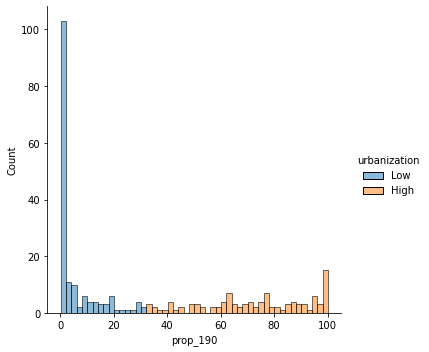

In [24]:
data_g = data_gdf_check.copy()

data_g['prop_190'] = data_g['prop_190'].astype('float')

# Categorize (level of precarization)
data_g['urbanization'] = ""
# set threshold based on full dataset (n=336 valid obs.)
cat_threshold = np.mean(data_g['prop_190'][data_g['built_pix']>0])
data_g['urbanization'][data_g['prop_190']>cat_threshold] = "High"
data_g['urbanization'][data_g['prop_190']<=cat_threshold] = "Low"

# Plot histogram with categories
sns.displot(data_g[data_g['built_pix']>0],
            x='prop_190',
            binwidth=2,
            hue="urbanization",
            alpha=0.5
           )

print('n. obs. for urbanization = High :',data_g[data_g['urbanization']=='High'].shape[0])
print('n. obs. for urbanization = Low :',data_g[data_g['urbanization']=='Low'].shape[0])
print('threshold :',cat_threshold)

# REGRESSION PLOTS

### NOTE: Spearman regressions and associated scatterplots do not take into account spatial autocorrelation of the dependent variable and residuals. 

# SELECTED VARIABLE(S)

#### 'prop_4342'
In this subset (n=105), the both the size and proportion of 'dense precarious areas' are significantly correlated to diarrhoea.  
Globally, the size of this patch class is positively correlated to diarrhoea (+0.24, P=0.013). This correlation becomes very clear in areas where the PERCENTAGE of urbanized areas classified as 'dense precarious areas' is high (+0.50, P=0.001, n=38).

Results for ind. var ' Prec. areas (ha) ')
-----------------------------------------
Spearman's corr. for b_lev= High:  SpearmanrResult(correlation=0.4979999972095002, pvalue=0.0014645074995548611)
n =  38
Spearman's corr. for b_lev= Low:  SpearmanrResult(correlation=0.27580531627716925, pvalue=0.02387778428146003)
n =  67
Spearman's corr. for all observations:  SpearmanrResult(correlation=0.24070314741444646, pvalue=0.013382338263439958)
n =  105


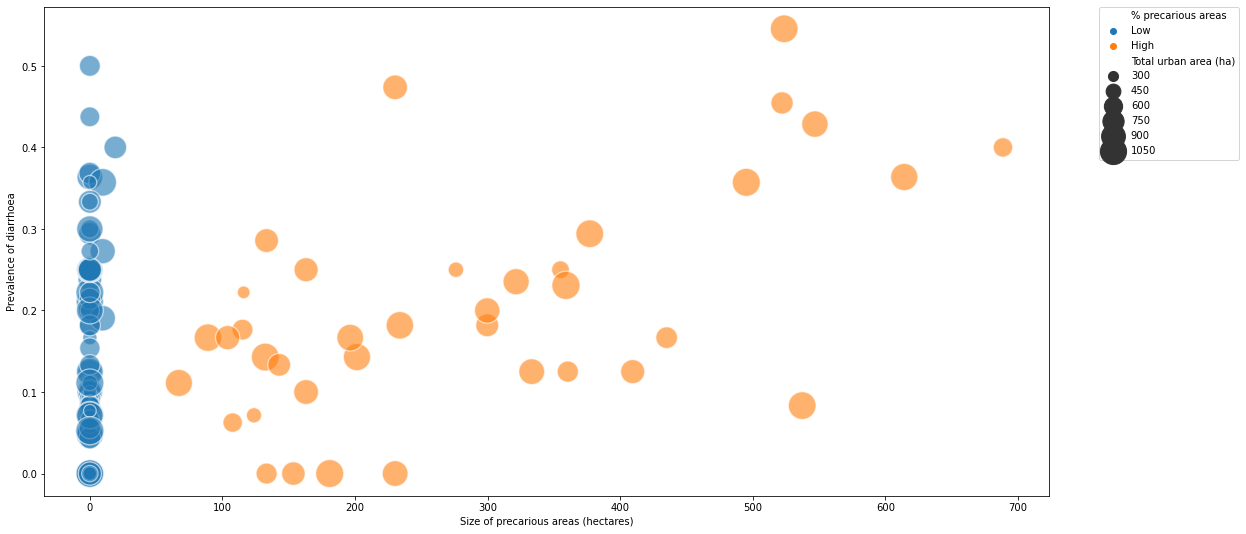

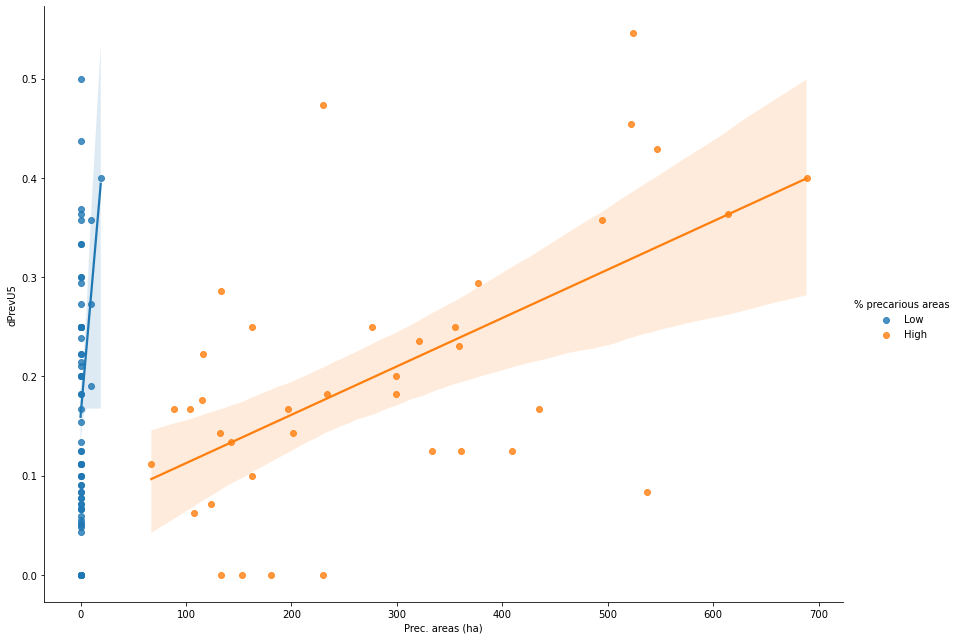

In [25]:
# See impact of precarious urbanization on diarrhoea :

# Get complete dataset
data_g = data.copy()

# Calculate buffer area
data_g['area'] = np.nan
data_g['area'][data_g.URBAN_RURA=='U'] = 2000*2000*np.pi # circle of 2km radius
data_g['area'][data_g.URBAN_RURA=='R'] = 5000*5000*np.pi # circle of 5km radius

# Calculate built-up area
data_g['Total urban area (ha)'] = np.nan
data_g['Total urban area (ha)'] = (data_g['built_pix']*300*300)/10000 # area in hectares

# Calculate area of 'precarious' patches
data_g['Prec. areas (ha)'] = np.nan
data_g['Prec. areas (ha)'] = (data_g['area']*(data_g['prop_4342']/100))/10000 # area in hectares

# Categorize (level of precarization)
# set threshold based on full dataset (n=267 obs. with at least 1 built-up pixel)
dummy_df = data_gdf_check.copy()
# calculate % dense precarious areas ('pc_DenPrAr')
dummy_df['pc_DenPrAr'] = np.nan
dummy_df['pc_DenPrAr'] = (dummy_df['prop_19043']+dummy_df['prop_19042'])/dummy_df['prop_190']
# set categories
data_g['% precarious areas'] = ""
cat_threshold = np.mean(dummy_df['pc_DenPrAr'][dummy_df['built_pix']>0].astype('float'))
data_g['% precarious areas'][data_g['pc_DenPrAr']>cat_threshold] = "High"
data_g['% precarious areas'][data_g['pc_DenPrAr']<=cat_threshold] = "Low"

x="Prec. areas (ha)"
y="dPrevU5"

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
ax.set(xlabel="Size of precarious areas (hectares)", ylabel = "Prevalence of diarrhoea")
g = sns.scatterplot(data=data_g, x=x, y=y,
                    hue="% precarious areas",
                    palette=["C0", "C1"],
                    size="Total urban area (ha)",
                    sizes=(100, 800),
                    alpha=0.6)

#plt.title('Subset : pixels with at least 1 ha. built-up surface')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

g = sns.lmplot(
    data=data_g,
    x=x, y=y,
    hue="% precarious areas",
    palette=["C0", "C1"],
    height=9,
    aspect=1.33)

print("Results for ind. var '",x,"')")
print("-----------------------------------------")
print("Spearman's corr. for b_lev= High: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='High'],data_g[y][data_g["% precarious areas"]=='High']))
print("n = ",data_g[x][data_g["% precarious areas"]=='High'].shape[0])
print("Spearman's corr. for b_lev= Low: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='Low'],data_g[y][data_g["% precarious areas"]=='Low']))
print("n = ",data_g[x][data_g["% precarious areas"]=='Low'].shape[0])
print("Spearman's corr. for all observations: ",stats.spearmanr(data_g[x],data_g[y]))
print("n = ",data_g[x].shape[0])

# ALTERNATIVE ANALYSES  
## Plots on urbanization trends  

#### Diarrhoea  (SAME results than full dataset)
As in the analysis with the full dataset (notebook '3a_1'), here diarrhoea is NOT significantly correlated with level of urbanization.

#### Water, sanitation and women's education  (DIFFERENT results than full dataset)
In this subset (high level of urbanization), NO SIGNIFICANT CORRELATION is found - these indicators present already relatively high levels, with little variations compared to the analysis with full dataset (notebook '3a_1').  
Globally, it seems that in larger urban areas the QUALITY of URBANIZATION ('precarious' or well structured) is a better predictor for diarrhoea than other 'classic' variables like access to WASH. Indeed, multiple regression results show that, for this subset, the proportion of precarious areas impacts more on diarrhoea than WASH.  
  
(!) Surprisingly, the proportion of urban patches (urban area/buffer area) is significantly correlated to basic sanitation only in spatial units where precarization level ('pc_DenPrAr') is high (+0.32, P=0.049, n=38). One must note that this result is hard to interpret: considering the large area of the spatial units (buffers), access to sanitation does not necessarily happen within the 'precarious' patch.

##### 'Precarious' areas (SAME than notebook '3a_1', nothing new to show) 
(subset's results described here are already shown in notebook '3a_1')   
Globally, size and proportion of urban areas ('built_pix' & 'prop_190') are NEGATIVELY correlated to 'precarious' urban areas in general ('pc_PrecAr'). The overall correlation is WEAK but SIGNIFICANT (-0.22, P=0.024, n=105).  
(!) However, for the specific type of 'precarious' urban areas that was selected ('pc_DenPrAr'), this correlation is INVERSED: there is a positive, weak but siginificant correlation with urbanization (+0.25, P=0.009, n=105). This is expected, as the urban patches of types '42' and '43' only happen in large urban areas (Abidjan and San Pédro); but it suggests that urbanization in CIV tends to generate such dense, precarious urban patches.

Results for ind. var ' prop_190 ')
-----------------------------------------
Spearman's corr. for b_lev= High:  SpearmanrResult(correlation=0.14586430404187867, pvalue=0.38221735469115614)
n =  38
Spearman's corr. for b_lev= Low:  SpearmanrResult(correlation=0.03049952097860641, pvalue=0.8064501054485621)
n =  67
Spearman's corr. for all observations:  SpearmanrResult(correlation=0.09486793676141274, pvalue=0.33572631997607505)
n =  105


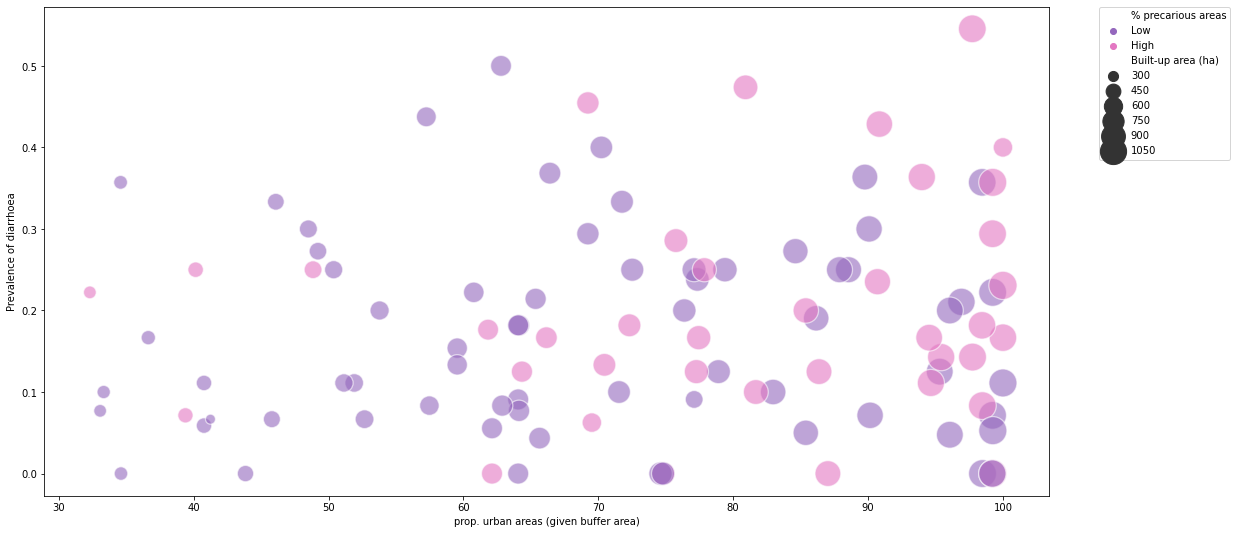

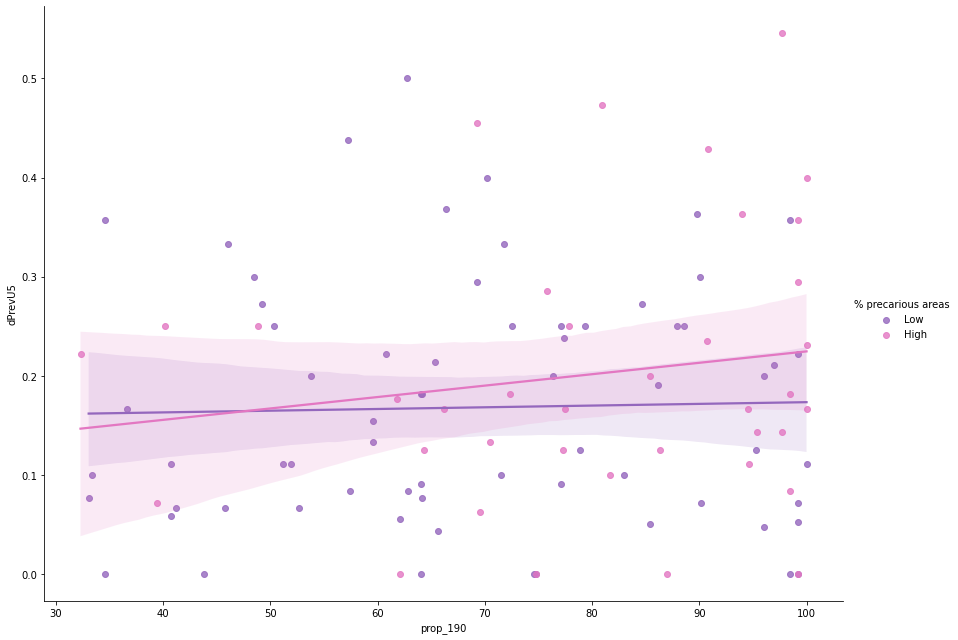

In [26]:
# See impact of urbanization level on diarrhoea :

# Get complete dataset
data_g = data.copy()

# Calculate built-up area
data_g['Built-up area (ha)'] = np.nan
data_g['Built-up area (ha)'] = (data_g['built_pix']*300*300)/10000 # area in hectares

# Categorize (level of precarization)
# set threshold based on full dataset (n=267 obs. with at least 1 built-up pixel)
dummy_df = data_gdf_check.copy()
# calculate % dense precarious areas ('pc_DenPrAr')
dummy_df['pc_DenPrAr'] = np.nan
dummy_df['pc_DenPrAr'] = (dummy_df['prop_19043']+dummy_df['prop_19042'])/dummy_df['prop_190']
# set categories
data_g['% precarious areas'] = ""
cat_threshold = np.mean(dummy_df['pc_DenPrAr'][dummy_df['built_pix']>0].astype('float'))
data_g['% precarious areas'][data_g['pc_DenPrAr']>cat_threshold] = "High"
data_g['% precarious areas'][data_g['pc_DenPrAr']<=cat_threshold] = "Low"

x="prop_190"
y="dPrevU5"

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
ax.set(xlabel="prop. urban areas (given buffer area)", ylabel = "Prevalence of diarrhoea")
g = sns.scatterplot(data=data_g, x=x, y=y,
                    hue="% precarious areas",
                    palette=["C4", "C6"],
                    size="Built-up area (ha)",
                    sizes=(100, 800),
                    alpha=0.6)

#plt.title('Subset : pixels with at least 1 ha. built-up surface')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

g = sns.lmplot(
    data=data_g,
    x=x, y=y,
    hue="% precarious areas",
    palette=["C4", "C6"],
    height=9,
    aspect=1.33)

print("Results for ind. var '",x,"')")
print("-----------------------------------------")
print("Spearman's corr. for b_lev= High: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='High'],data_g[y][data_g["% precarious areas"]=='High']))
print("n = ",data_g[x][data_g["% precarious areas"]=='High'].shape[0])
print("Spearman's corr. for b_lev= Low: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='Low'],data_g[y][data_g["% precarious areas"]=='Low']))
print("n = ",data_g[x][data_g["% precarious areas"]=='Low'].shape[0])
print("Spearman's corr. for all observations: ",stats.spearmanr(data_g[x],data_g[y]))
print("n = ",data_g[x].shape[0])

Results for ind. var ' prop_190 ')
-----------------------------------------
Spearman's corr. for b_lev= High:  SpearmanrResult(correlation=-0.04669182782836746, pvalue=0.7807324663425049)
n =  38
Spearman's corr. for b_lev= Low:  SpearmanrResult(correlation=-0.001479663364560217, pvalue=0.9905184491266763)
n =  67
Spearman's corr. for all observations:  SpearmanrResult(correlation=0.07796732023314729, pvalue=0.4291960022185525)
n =  105


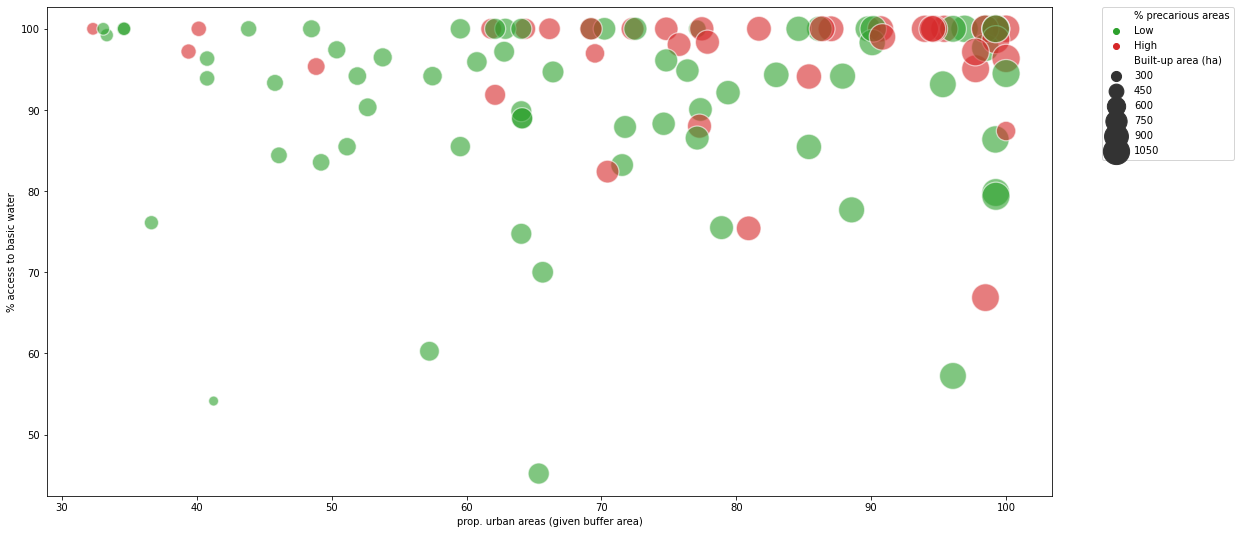

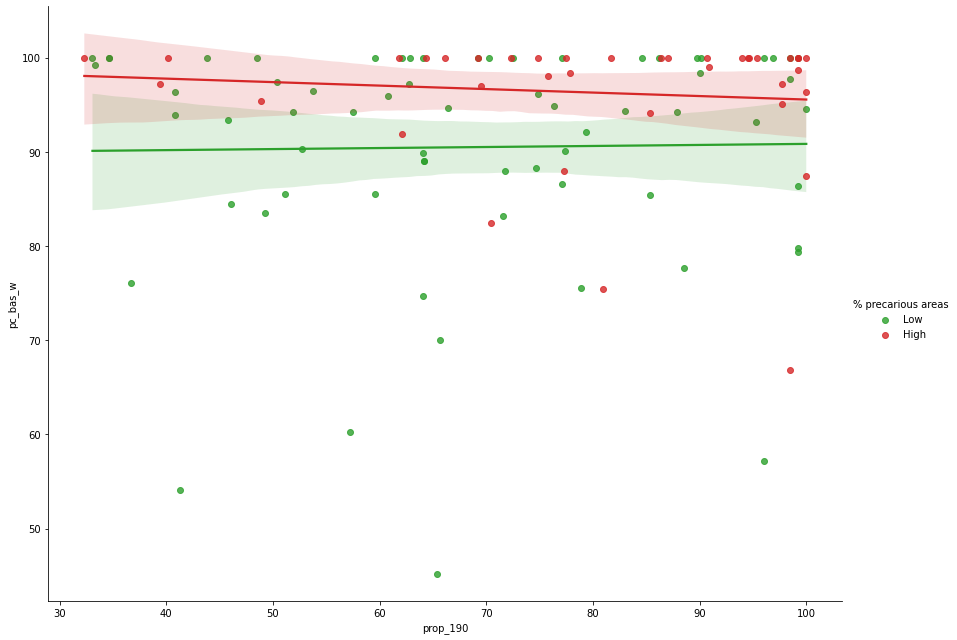

In [30]:
# See impact of urbanization level on access to basic water:

# Get complete dataset
data_g = data.copy()

# Calculate built-up area
data_g['Built-up area (ha)'] = np.nan
data_g['Built-up area (ha)'] = (data_g['built_pix']*300*300)/10000 # area in hectares

# Categorize (level of precarization)
# set threshold based on full dataset (n=267 obs. with at least 1 built-up pixel)
dummy_df = data_gdf_check.copy()
# calculate % dense precarious areas ('pc_DenPrAr')
dummy_df['pc_DenPrAr'] = np.nan
dummy_df['pc_DenPrAr'] = (dummy_df['prop_19043']+dummy_df['prop_19042'])/dummy_df['prop_190']
# set categories
data_g['% precarious areas'] = ""
cat_threshold = np.mean(dummy_df['pc_DenPrAr'][dummy_df['built_pix']>0].astype('float'))
data_g['% precarious areas'][data_g['pc_DenPrAr']>cat_threshold] = "High"
data_g['% precarious areas'][data_g['pc_DenPrAr']<=cat_threshold] = "Low"

x="prop_190"
y="pc_bas_w"

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
ax.set(xlabel="prop. urban areas (given buffer area)", ylabel = "% access to basic water")
g = sns.scatterplot(data=data_g, x=x, y=y,
                    hue="% precarious areas",
                    palette=["C2", "C3"],
                    size="Built-up area (ha)",
                    sizes=(100, 800),
                    alpha=0.6)

#plt.title('Subset : pixels with at least 1 ha. built-up surface')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

g = sns.lmplot(
    data=data_g,
    x=x, y=y,
    hue="% precarious areas",
    palette=["C2", "C3"],
    height=9,
    aspect=1.33)

print("Results for ind. var '",x,"')")
print("-----------------------------------------")
print("Spearman's corr. for b_lev= High: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='High'],data_g[y][data_g["% precarious areas"]=='High']))
print("n = ",data_g[x][data_g["% precarious areas"]=='High'].shape[0])
print("Spearman's corr. for b_lev= Low: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='Low'],data_g[y][data_g["% precarious areas"]=='Low']))
print("n = ",data_g[x][data_g["% precarious areas"]=='Low'].shape[0])
print("Spearman's corr. for all observations: ",stats.spearmanr(data_g[x],data_g[y]))
print("n = ",data_g[x].shape[0])

Results for ind. var ' prop_190 ')
-----------------------------------------
Spearman's corr. for b_lev= High:  SpearmanrResult(correlation=0.3209457653684174, pvalue=0.04945183968388526)
n =  38
Spearman's corr. for b_lev= Low:  SpearmanrResult(correlation=-0.0337753565042517, pvalue=0.7861311882123614)
n =  67
Spearman's corr. for all observations:  SpearmanrResult(correlation=0.12610777170758442, pvalue=0.19988616583395427)
n =  105


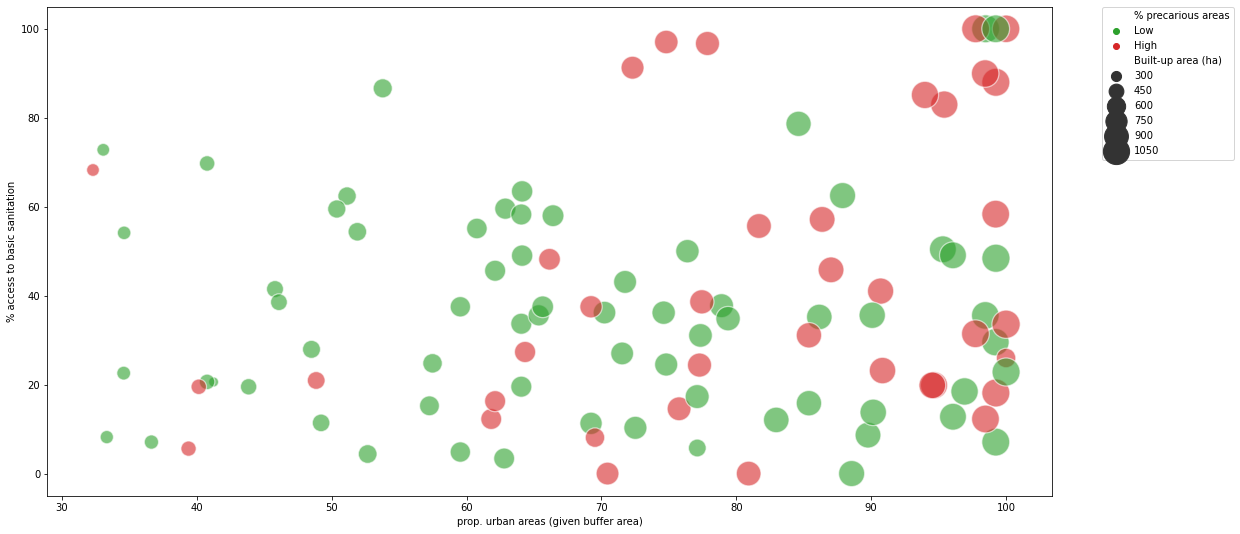

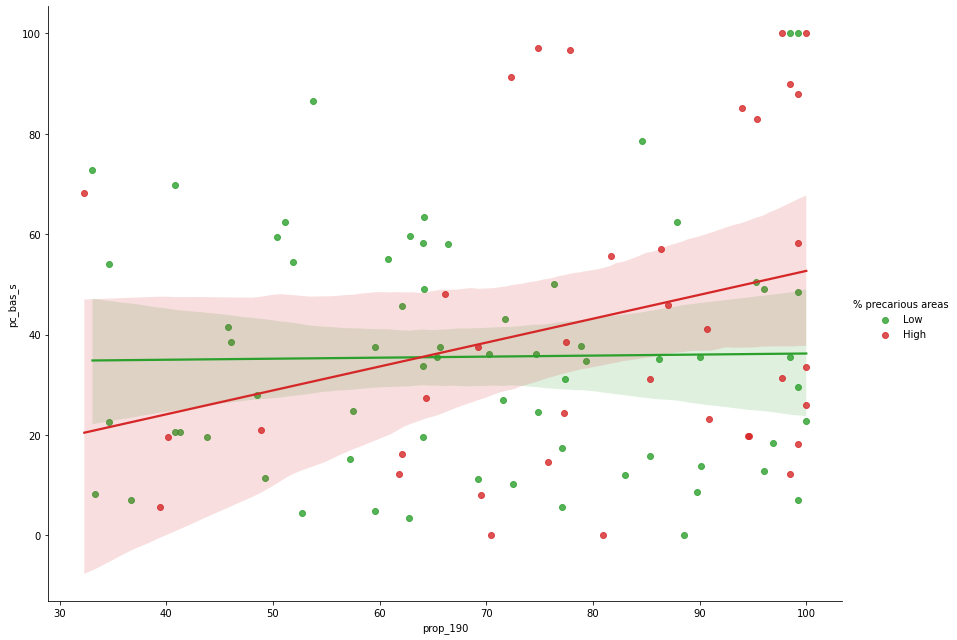

In [31]:
# See impact of urbanization level on access to basic sanitation:

# Get complete dataset
data_g = data.copy()

# Calculate built-up area
data_g['Built-up area (ha)'] = np.nan
data_g['Built-up area (ha)'] = (data_g['built_pix']*300*300)/10000 # area in hectares

# Categorize (level of precarization)
# set threshold based on full dataset (n=267 obs. with at least 1 built-up pixel)
dummy_df = data_gdf_check.copy()
# calculate % dense precarious areas ('pc_DenPrAr')
dummy_df['pc_DenPrAr'] = np.nan
dummy_df['pc_DenPrAr'] = (dummy_df['prop_19043']+dummy_df['prop_19042'])/dummy_df['prop_190']
# set categories
data_g['% precarious areas'] = ""
cat_threshold = np.mean(dummy_df['pc_DenPrAr'][dummy_df['built_pix']>0].astype('float'))
data_g['% precarious areas'][data_g['pc_DenPrAr']>cat_threshold] = "High"
data_g['% precarious areas'][data_g['pc_DenPrAr']<=cat_threshold] = "Low"

x="prop_190"
y="pc_bas_s"

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
ax.set(xlabel="prop. urban areas (given buffer area)", ylabel = "% access to basic sanitation")
g = sns.scatterplot(data=data_g, x=x, y=y,
                    hue="% precarious areas",
                    palette=["C2", "C3"],
                    size="Built-up area (ha)",
                    sizes=(100, 800),
                    alpha=0.6)

#plt.title('Subset : pixels with at least 1 ha. built-up surface')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

g = sns.lmplot(
    data=data_g,
    x=x, y=y,
    hue="% precarious areas",
    palette=["C2", "C3"],
    height=9,
    aspect=1.33)

print("Results for ind. var '",x,"')")
print("-----------------------------------------")
print("Spearman's corr. for b_lev= High: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='High'],data_g[y][data_g["% precarious areas"]=='High']))
print("n = ",data_g[x][data_g["% precarious areas"]=='High'].shape[0])
print("Spearman's corr. for b_lev= Low: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='Low'],data_g[y][data_g["% precarious areas"]=='Low']))
print("n = ",data_g[x][data_g["% precarious areas"]=='Low'].shape[0])
print("Spearman's corr. for all observations: ",stats.spearmanr(data_g[x],data_g[y]))
print("n = ",data_g[x].shape[0])

Results for ind. var ' prop_190 ')
-----------------------------------------
Spearman's corr. for b_lev= High:  SpearmanrResult(correlation=-0.15217034343230146, pvalue=0.3617515119078346)
n =  38
Spearman's corr. for b_lev= Low:  SpearmanrResult(correlation=0.10582718028784263, pvalue=0.3940319600498985)
n =  67
Spearman's corr. for all observations:  SpearmanrResult(correlation=0.0016044790627200442, pvalue=0.9870395580258231)
n =  105


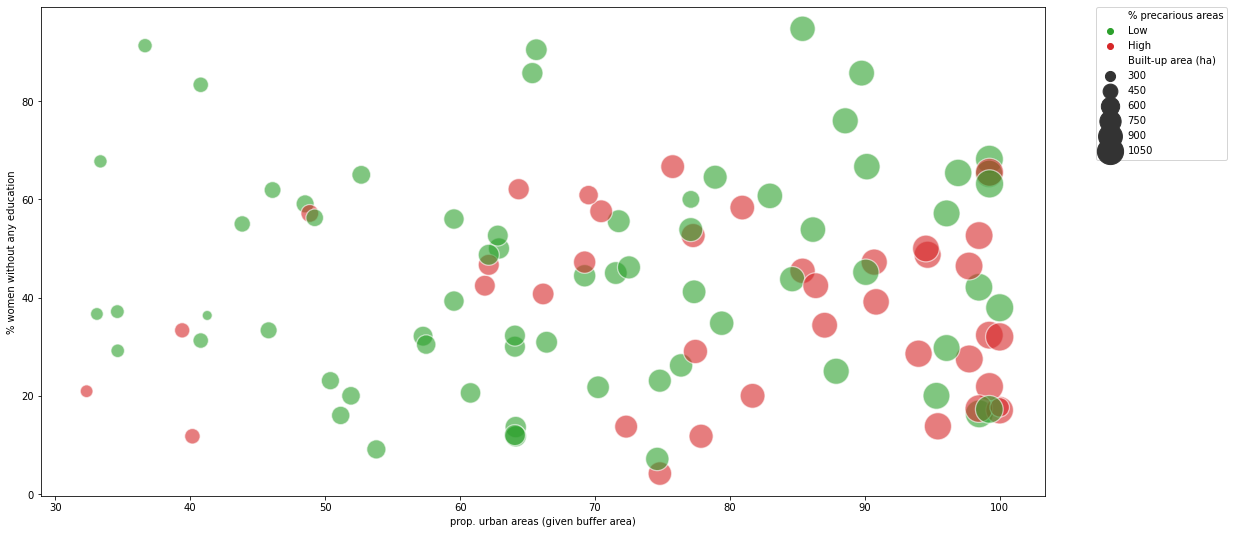

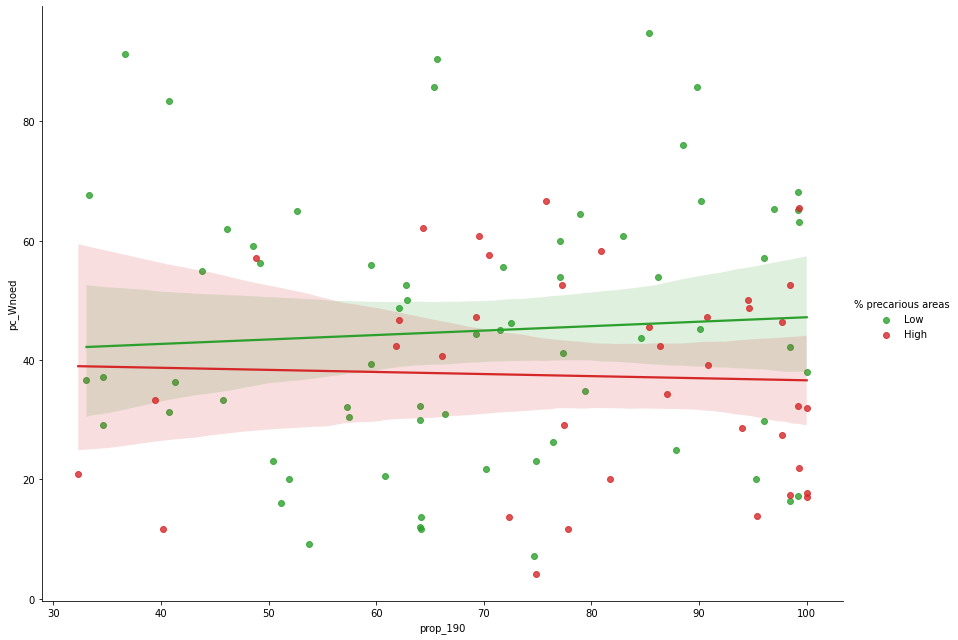

In [32]:
# See impact of urbanization level on access to education (women):

# Get complete dataset
data_g = data.copy()

# Calculate built-up area
data_g['Built-up area (ha)'] = np.nan
data_g['Built-up area (ha)'] = (data_g['built_pix']*300*300)/10000 # area in hectares

# Categorize (level of precarization)
# set threshold based on full dataset (n=267 obs. with at least 1 built-up pixel)
dummy_df = data_gdf_check.copy()
# calculate % dense precarious areas ('pc_DenPrAr')
dummy_df['pc_DenPrAr'] = np.nan
dummy_df['pc_DenPrAr'] = (dummy_df['prop_19043']+dummy_df['prop_19042'])/dummy_df['prop_190']
# set categories
data_g['% precarious areas'] = ""
cat_threshold = np.mean(dummy_df['pc_DenPrAr'][dummy_df['built_pix']>0].astype('float'))
data_g['% precarious areas'][data_g['pc_DenPrAr']>cat_threshold] = "High"
data_g['% precarious areas'][data_g['pc_DenPrAr']<=cat_threshold] = "Low"

x="prop_190"
y="pc_Wnoed"

fig, ax = plt.subplots()
fig.set_size_inches(18, 9)
ax.set(xlabel="prop. urban areas (given buffer area)", ylabel = "% women without any education")
g = sns.scatterplot(data=data_g, x=x, y=y,
                    hue="% precarious areas",
                    palette=["C2", "C3"],
                    size="Built-up area (ha)",
                    sizes=(100, 800),
                    alpha=0.6)

#plt.title('Subset : pixels with at least 1 ha. built-up surface')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

g = sns.lmplot(
    data=data_g,
    x=x, y=y,
    hue="% precarious areas",
    palette=["C2", "C3"],
    height=9,
    aspect=1.33)

print("Results for ind. var '",x,"')")
print("-----------------------------------------")
print("Spearman's corr. for b_lev= High: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='High'],data_g[y][data_g["% precarious areas"]=='High']))
print("n = ",data_g[x][data_g["% precarious areas"]=='High'].shape[0])
print("Spearman's corr. for b_lev= Low: ",stats.spearmanr(data_g[x][data_g["% precarious areas"]=='Low'],data_g[y][data_g["% precarious areas"]=='Low']))
print("n = ",data_g[x][data_g["% precarious areas"]=='Low'].shape[0])
print("Spearman's corr. for all observations: ",stats.spearmanr(data_g[x],data_g[y]))
print("n = ",data_g[x].shape[0])